In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from pathlib import Path
import matplotx
import matplotlib
import optuna
from collections import OrderedDict

### Utility Functions

In [2]:
def show_bar_values(
    fmt: str = "{}", alignment: str = "vertical", ax: plt.Axes = None, size: int = 12
) -> None:
    if ax is None:
        ax = plt.gca()

    # check alignment
    if alignment not in ["vertical", "horizontal"]:
        msg = "Unknown alignment {}".format(alignment)
        msg += " (should be horizontal or vertical)"
        raise ValueError(msg)

    # turn off ticks and grid
    if alignment == "vertical":
        ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    elif alignment == "horizontal":
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    ax.grid(False)

    # remove margins
    ax.margins(x=0, y=0)

    data_to_axis = ax.transData + ax.transAxes.inverted()
    axis_to_data = ax.transAxes + ax.transData.inverted()

    for rect in ax.patches:
        if alignment == "vertical":
            height = rect.get_height()
            ypos_ax = data_to_axis.transform([1.0, height])
            ypos = axis_to_data.transform(ypos_ax - 0.1)[1]
            xpos = rect.get_x() + rect.get_width() / 2
            s = fmt.format(height)
            ha = "center"
            va = "bottom"
        elif alignment == "horizontal":
            width = rect.get_width()
            xpos_ax = data_to_axis.transform([1.0, width])
            xpos = axis_to_data.transform(xpos_ax - 0.1)[1]
            ypos = rect.get_y() + rect.get_height() / 2
            s = fmt.format(width)
            ha = "right"
            va = "center"

        ax.text(
            xpos,
            ypos,
            s,
            size=size,
            weight="bold",
            ha=ha,
            va=va,
            color="white",
        )

### Config

In [3]:
Data = namedtuple('Data', ["type","name", "path", "config"])

DATA_PATH = Path("data")
OUTPUT_PATH = Path("output")
STUDY_PATH = Path("study")

In [4]:
POL_CLS_UUID = "66dc899c4c4f4e4f822d02bdddb18f80"
experiments = [
 'classification|default-of-credit-card-clients',
 'classification|heloc',
 'classification|eye_movements',
 'classification|Higgs',
 'classification|pol',
 'classification|albert',
 'classification|road-safety',
 'classification|MiniBooNE',
 'classification|covertype',
 'classification|jannis',
 'classification|Bioresponse',
 'regression|cpu_act',
 'regression|Ailerons',
 'regression|yprop_4_1',
 'regression|superconduct',
 'regression|Allstate_Claims_Severity',
 'regression|topo_2_1',
 'regression|Mercedes_Benz_Greener_Manufacturing',
]

datasets = []
for experiment in experiments:
    typ, name = experiment.split("|")
    folder = DATA_PATH/name
    config_files = list(folder.glob("*config*"))
    config = np.load(config_files[0], allow_pickle=True).item()
    config["n_iter"] = len(config_files)
    datasets.append(Data(typ, name, folder, config))

dataset_dict = {d.name: d for d in datasets}

In [5]:
dataset_rename_map = {'Ailerons': 'Ailerons',
 'albert': 'albert',
 'Allstate_Claims_Severity': 'Allstate',
 'Bioresponse': 'Bioresponse',
 'covertype': 'covertype',
 'cpu_act': 'cpu_act',
 'default-of-credit-card-clients': 'default-credit-card',
 'eye_movements': 'eye_movements',
 'heloc': 'heloc',
 'Higgs': 'Higgs',
 'jannis': 'jannis',
 'Mercedes_Benz_Greener_Manufacturing': 'Mercedes',
 'MiniBooNE': 'MiniBooNE',
 'pol': 'pol',
 'road-safety': 'road-safety',
 'superconduct': 'superconduct',
 'topo_2_1': 'topo_2_1',
 'yprop_4_1': 'yprop_4_1'}


In [6]:
benchmark_format = lambda x: " ".join(x.split("_")).title()
mdl_rename_map = {
    "HistGradientBoostingTree": "HistGBDT",
    "GradientBoostingTree": "GBDT",
}

### Data Summary

In [31]:
data_summary_df = pd.read_parquet("data/data_summary.parquet")
data_summary_df = data_summary_df.loc[data_summary_df.dataset_name.isin([d.name for d in datasets])]
data_summary_df.dataset_name = data_summary_df.dataset_name.map(dataset_rename_map)
data_summary_df.columns = ["Dataset", "Type", "Has Categorical", "# Folds", "# Features", "Train Size", "Validation Size", "Test Size"]
# data_summary_df['Benchmark'] = ""
data_summary_df.loc[(data_summary_df.Type == "classification") & (data_summary_df['Has Categorical']), "Benchmark"] = "Categorical Classification"
data_summary_df.loc[(data_summary_df.Type == "classification") & (~data_summary_df['Has Categorical']), "Benchmark"] = "Numeric Classification"
data_summary_df.loc[(data_summary_df.Type == "regression") & (data_summary_df['Has Categorical']), "Benchmark"] = "Categorical Regression"
data_summary_df.loc[(data_summary_df.Type == "regression") & (~data_summary_df['Has Categorical']), "Benchmark"] = "Numeric Regression"
data_summary_df.sort_values(by=["Benchmark", "Dataset"], inplace=True)
data_summary_df

,Dataset,Type,Has Categorical,# Folds,# Features,Train Size,Validation Size,Test Size,Benchmark
2,albert,classification,True,1,31,10000,14475,33777,Categorical Classification
9,covertype,classification,True,1,54,10000,50000,50000,Categorical Classification
11,default-credit-card,classification,True,3,21,9290,1194,2788,Categorical Classification
12,eye_movements,classification,True,3,23,5325,684,1599,Categorical Classification
23,road-safety,classification,True,1,32,10000,30528,50000,Categorical Classification
3,Allstate,regression,True,1,124,10000,50000,50000,Categorical Regression
18,Mercedes,regression,True,5,359,2946,378,885,Categorical Regression
26,topo_2_1,regression,True,3,255,6219,799,1867,Categorical Regression
6,Bioresponse,classification,False,5,419,2403,309,722,Numeric Classification
14,Higgs,classification,False,1,24,10000,50000,50000,Numeric Classification


In [32]:
print(
    data_summary_df.to_latex(
        columns=[
            "Benchmark",
            "Dataset",
            "Type",
            "# Folds",
            "# Features",
            "Train Size",
            "Test Size",
        ],
        index=False,
        formatters={"Type": lambda x: x.capitalize()},
        bold_rows=True,
        caption="Summary of datasets used in the experiments.",
        label="tab:datasets",
    )
)

\begin{table}
\centering
\caption{Summary of datasets used in the experiments.}
\label{tab:datasets}
\begin{tabular}{lllrrrr}
\toprule
                 Benchmark &             Dataset &           Type &  \# Folds &  \# Features &  Train Size &  Test Size \\
\midrule
Categorical Classification &              albert & Classification &        1 &          31 &       10000 &      33777 \\
Categorical Classification &           covertype & Classification &        1 &          54 &       10000 &      50000 \\
Categorical Classification & default-credit-card & Classification &        3 &          21 &        9290 &       2788 \\
Categorical Classification &       eye\_movements & Classification &        3 &          23 &        5325 &       1599 \\
Categorical Classification &         road-safety & Classification &        1 &          32 &       10000 &      50000 \\
    Categorical Regression &            Allstate &     Regression &        1 &         124 &       10000 &      50000 \\
    Ca

C:\Users\manuj\AppData\Local\Temp\ipykernel_43124\162298389.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_summary_df.to_latex(columns=["Benchmark", "Dataset", "Type", "# Folds", "# Features", "Train Size", "Test Size"],index=False, formatters={"Type": lambda x: x.capitalize()}, bold_rows=True, caption="Summary of datasets used in the experiments.", label="tab:datasets"))


### LeoGrin Benchmark Table

In [125]:
experiment_results = pd.read_parquet("data/experiment_results_best_rows.parquet")
experiment_results.dataset = experiment_results.dataset.map(dataset_rename_map)
experiment_results.benchmark = experiment_results.benchmark.map(benchmark_format)
experiment_results.rename(columns={
    "dataset": "Dataset",
    "benchmark": "Benchmark",
    "model_name": "Model",
}, inplace=True)
experiment_results.head()

,Benchmark,Dataset,Model,mean_test_score,max_test_score,min_test_score,std_test_score,mean_time,std_time,test_scores,times,index
0,Numerical Regression Medium,Ailerons,GANDALF,0.864613,0.86616,0.863550,0.001119,11.039673,1.790702,"[0.8641285300254822,0.8661600947380066,0.86355...","[13.085770606994627,11.308923244476318,8.72432...",NaN
1,Categorical Classification Medium,albert,GANDALF,0.685300,NaN,NaN,NaN,26.371789,NaN,None,None,NaN
3,Categorical Regression Medium,Allstate,GANDALF,0.591058,NaN,NaN,NaN,202.469212,NaN,None,None,NaN
4,Numerical Classification Medium,Bioresponse,GANDALF,0.881648,0.90928,0.849771,0.020634,6.990565,1.542113,"[0.8722430467605591,0.8497711420059204,0.89762...","[5.676318407058716,4.947674989700317,8.5587186...",NaN
5,Categorical Classification Medium,covertype,GANDALF,0.932200,NaN,NaN,NaN,213.263477,NaN,None,None,NaN


#### Mean and STD Scores

In [ ]:
nw_cols = ["Dataset","GANDALF", "XGBoost", "HistGBDT", "GBDT", "RandomForest", "FT Transformer", "Resnet", "SAINT", "MLP"]

In [139]:
test_scores = pd.pivot_table(experiment_results.reset_index(), index=["Benchmark", "Dataset"], columns="Model", values="mean_test_score")
test_scores = (test_scores*100)
test_scores.rename(columns=mdl_rename_map, inplace=True)
test_scores = test_scores.reset_index()[nw_cols]
best_scores = test_scores.max(axis=1).values.tolist()
# format bold if in best scores
formatter = lambda x: r"\textbf{"+f"{x:.2f}"+"}" if x in best_scores else f"{x:.2f}"
print(test_scores.to_latex(
    caption="Test scores on \citet{leogrin_benchmark}. For classification Accuracy and for regression $R^2$ score is reported. The best performing model is highlighted in bold.",
    label="tab:leo_grin_results",
    bold_rows=True,
    escape=False,
    index=False,
    formatters = [lambda x: x.replace("_","\_")]+([formatter]*(len(test_scores.columns)-1)),
    na_rep="-"
))

\begin{table}
\centering
\caption{Test scores on \citet{leogrin_benchmark}. For classification Accuracy and for regression $R^2$ score is reported. The best performing model is highlighted in bold.}
\label{tab:leo_grin_results}
\begin{tabular}{lrrrrrrrrr}
\toprule
            Dataset &        GANDALF &        XGBoost & HistGBDT &  GBDT &  RandomForest & FT Transformer & Resnet &          SAINT &   MLP \\
\midrule
             albert & \textbf{68.53} &          65.70 &    65.78 & 65.76 &         65.53 &          65.63 &  65.23 &          65.52 & 65.32 \\
          covertype & \textbf{93.22} &          86.58 &    84.98 & 85.43 &         85.86 &          85.93 &  83.96 &          85.33 & 83.32 \\
default-credit-card & \textbf{72.80} &          72.08 &    72.00 & 72.09 &         72.13 &          71.90 &  71.40 &          71.90 & 71.41 \\
     eye\_movements & \textbf{67.89} &          66.85 &    64.23 & 64.67 &         66.21 &          60.00 &  59.97 &          60.56 & 60.54 \\
        roa

C:\Users\manuj\AppData\Local\Temp\ipykernel_43124\3805826263.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_scores = test_scores.max(axis=1).values.tolist()
C:\Users\manuj\AppData\Local\Temp\ipykernel_43124\3805826263.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(test_scores.to_latex(


In [148]:
test_scores_std = pd.pivot_table(experiment_results.reset_index(), index=["Benchmark", "Dataset"], columns="Model", values="std_test_score")
test_scores_std.rename(columns={
    "HistGradientBoostingTree": "HistGBDT",
    "GradientBoostingTree": "GBDT",
}, inplace=True)
test_scores_std = test_scores_std.reset_index()[nw_cols]
formatter = lambda x: f"{x:.2E}"
print(test_scores_std.to_latex(
    caption="Standard deviation of test scores on \citet{leogrin_benchmark}. For classification Accuracy and for regression $R^2$ score is reported.",
    label="tab:leo_grin_results_std",
    bold_rows=True,
    escape=False,
    index=False,
    formatters = [lambda x: x.replace("_","\_")]+([formatter]*(len(test_scores.columns)-1)),
    na_rep="-"
))

\begin{table}
\centering
\caption{Standard deviation of test scores on \citet{leogrin_benchmark}. For classification Accuracy and for regression $R^2$ score is reported.}
\label{tab:leo_grin_results_std}
\begin{tabular}{lrrrrrrrrr}
\toprule
            Dataset &  GANDALF &  XGBoost & HistGBDT &     GBDT & RandomForest & FT Transformer &   Resnet &    SAINT &      MLP \\
\midrule
default-credit-card & 5.01E-03 & 6.30E-03 & 6.59E-03 & 7.43E-03 &     4.31E-03 &       3.98E-03 & 1.08E-02 & 5.69E-03 & 5.76E-03 \\
     eye\_movements & 9.21E-03 & 3.57E-03 & 7.36E-03 & 4.09E-03 &     5.22E-03 &       1.29E-02 & 6.68E-03 & 7.08E-03 & 1.16E-02 \\
           Mercedes & 1.59E-02 & 8.41E-01 & 8.46E-01 & 8.42E-01 &     8.20E-01 &       8.35E-01 & 8.38E-01 & 8.71E-01 & 7.91E-01 \\
         topo\_2\_1 & 2.32E-02 & 4.21E-04 & 4.19E-04 & 4.42E-04 &     4.75E-04 &       4.67E-04 & 4.99E-04 & 5.35E-04 & 4.23E-04 \\
        Bioresponse & 2.06E-02 & 1.74E-02 &        - & 1.26E-02 &     1.32E-02 &       1.5

C:\Users\manuj\AppData\Local\Temp\ipykernel_43124\1187903166.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(test_scores_std.to_latex(


#### Scores, Param and Mac Counts - Aggregate

In [126]:
gandalf_specs = pd.read_parquet("output/gandalf_macs_params.parquet")
other_dl_spcs = pd.read_parquet("../tabular-benchmark/model_specs.parquet")
specs = pd.concat([gandalf_specs, other_dl_spcs], axis=0)
specs = specs.loc[specs.dataset.isin([d.name for d in datasets])]
specs.drop(columns=["missing"], inplace=True)
specs.columns = ['Dataset', 'Model', 'macs', 'params', "MACs", "# Params"]
specs = specs.merge(experiment_results[['Dataset', "Model", "mean_test_score", "mean_time"]], on=["Dataset", "Model"])
specs.head()

,Dataset,Model,macs,params,MACs,# Params,mean_test_score,mean_time
0,heloc,GANDALF,39088.0,39952.0,39.088K,39.952K,0.722619,11.277521
1,eye_movements,GANDALF,9568.0,9734.0,9.568K,9.734K,0.678936,11.988180
2,Higgs,GANDALF,35968.0,36690.0,35.968K,36.690K,0.752300,97.720078
3,pol,GANDALF,13648.0,13880.0,13.648K,13.880K,0.989797,20.310946
4,albert,GANDALF,517024.0,520758.0,517.024K,520.758K,0.685300,26.371789


In [127]:
specs[["Dataset", "Model", "MACs", "# Params"]].sort_values(by=["Dataset", "Model"]).to_csv("figures/model_specs.csv", index=False)

In [128]:
# standardize test scores between 0 and 1 for each dataset
# specs["mean_test_score"] = specs.groupby("Dataset")["mean_test_score"].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# specs["mean_time"] = specs.groupby("Dataset")["mean_time"].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# specs["macs"] = specs.groupby("Dataset")["macs"].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# specs["params"] = specs.groupby("Dataset")["params"].transform(lambda x: (x-x.min())/(x.max()-x.min()))

In [129]:
plot_df = specs.copy()
# plot_df['macs'] = np.log(plot_df['macs'])
# plot_df['params'] = np.log(plot_df['params'])

In [130]:
experiment_results['Model'] = experiment_results['Model'].map(mdl_rename_map).fillna(experiment_results['Model'])
test_scores = pd.pivot_table(experiment_results.reset_index(), index=["Benchmark", "Dataset"], columns="Model", values="mean_test_score")
# min_ = test_scores.quantile(0.1, axis=1).values
min_ = test_scores.min(axis=1).values
max_ = test_scores.max(axis=1).values
norm_experiment_results = pd.DataFrame((test_scores.values - min_.reshape(-1, 1))/(max_-min_).reshape(-1, 1), columns=test_scores.columns, index=test_scores.index)
my_order = norm_experiment_results.median().sort_values(ascending=False).index
my_order_nn = [i for i in my_order if i in specs.Model.unique()]

norm_experiment_results = norm_experiment_results.reset_index().drop(columns="Benchmark").melt(id_vars="Dataset")

# my_order = norm_test_scores.median().sort_values(ascending=False).index
# my_order_nn = [i for i in my_order if i in specs.Model.unique()]
norm_experiment_results.columns = ['Dataset', 'Model', 'Test Score']
norm_experiment_results.head()

,Dataset,Model,Test Score
0,albert,FT Transformer,0.120246
1,covertype,FT Transformer,0.263339
2,default-credit-card,FT Transformer,0.358411
3,eye_movements,FT Transformer,0.002633
4,road-safety,FT Transformer,0.283554


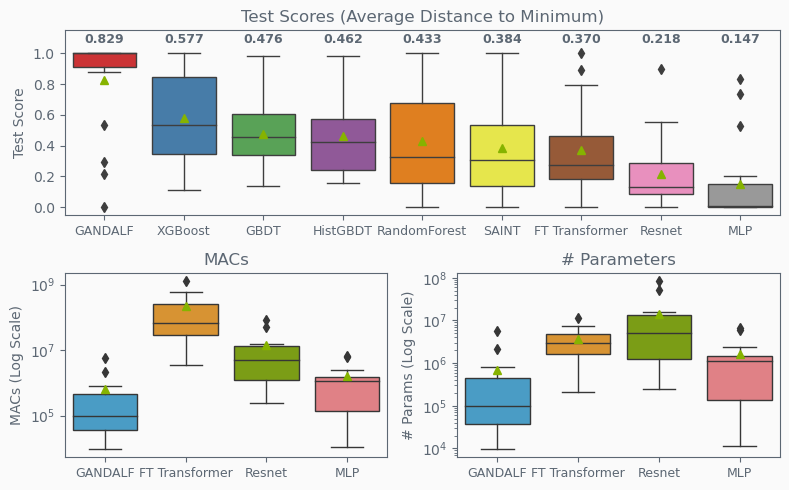

In [135]:
with plt.style.context(matplotx.styles.ayu["light"]):
    fig = plt.figure(figsize=(8, 5))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[:-1, :])
    ax2 = fig.add_subplot(gs[-1, :-1])
    ax3 = fig.add_subplot(gs[-1, -1])
    axs = [ax1, ax2, ax3]
    # box plot of mean scores
    sns.boxplot(
        data=norm_experiment_results,
        x="Model",
        y="Test Score",
        ax=axs[0],
        palette="Set1",
        showmeans=True,
        order=my_order,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
    )
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Test Score")
    # Annotate mean test scores for each box
    for i, model in enumerate(my_order):
        mean_score = norm_experiment_results.loc[norm_experiment_results.Model == model, "Test Score"].mean()
        axs[0].annotate(
            f"{mean_score:.3f}",
            # xy=(i, mean_score),
            xy=(i, 1.0),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            #bold
            fontweight="bold",
        )
    axs[0].set_ylim(None, 1.15)
    # reduce font size of xticks
    plt.setp(axs[0].get_xticklabels(), fontsize=9)

    axs[0].set_title("Test Scores (Average Distance to Minimum)")
    # xtick rotation of first subplot
    # plt.setp(axs[0].get_xticklabels(), rotation=45)

    sns.boxplot(
        x="Model",
        y="macs",
        data=specs,
        ax=axs[1],
        showmeans=True,
        order=my_order_nn,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
    )
    axs[1].set_ylabel("MACs (Log Scale)")
    axs[1].set_xlabel("")
    axs[1].set_title("MACs")
    # plt.xticks(rotation=45)
    # log y scale
    axs[1].set_yscale("log")
    plt.setp(axs[1].get_xticklabels(), fontsize=9)
    sns.boxplot(
        x="Model",
        y="params",
        data=specs,
        ax=axs[2],
        order=my_order_nn,
        showmeans=True,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
    )
    axs[2].set_ylabel("# Params (Log Scale)")
    axs[2].set_xlabel("")
    axs[2].set_title("# Parameters")
    # plt.xticks(rotation=45)
    # log y scale
    axs[2].set_yscale("log")
    plt.setp(axs[2].get_xticklabels(), fontsize=9)
    plt.tight_layout()
    plt.savefig("figures/aggregate_plot.pdf", transparent=True, bbox_inches="tight")
    plt.show()

### Tuning Trajectories

In [528]:
tuning_results = pd.read_parquet("data/tuning_results.parquet")
tuning_results["_timestamp"] = tuning_results["_timestamp"].astype(np.int64)
tuning_results = tuning_results[['benchmark', "data__keyword", "model_name", "model_type", '_timestamp', "mean_test_score"]]

experiment_results = pd.read_parquet("data/experiment_results_best_rows.parquet")
experiment_results['mean_test_score'] = experiment_results['mean_test_score'].clip(0, 1)
test_scores = pd.pivot_table(experiment_results.reset_index(), index=["benchmark", "dataset"], columns="model_name", values="mean_test_score")
min_ = test_scores.quantile(0.1,axis=1)
min_ = test_scores.min(axis=1)
min_.name = "min_score"
max_ = test_scores.max(axis=1)
max_.name = "max_score"
min_max_scores = min_.reset_index()[['dataset', 'min_score']].set_index("dataset").join(max_.reset_index()[['dataset', 'max_score']].set_index("dataset"))
min_max_scores.index.name = "data__keyword"

full_benchmark = pd.read_parquet("data/benchmark_total.parquet")
full_benchmark = full_benchmark[['benchmark', "data__keyword", "model_name", "model_type", '_timestamp', "mean_test_score"]]
full_benchmark = pd.concat([full_benchmark, tuning_results])

full_benchmark = full_benchmark.merge(min_max_scores.reset_index(), on="data__keyword")
full_benchmark['dist_to_best'] = (full_benchmark['max_score']-full_benchmark['mean_test_score'])/(full_benchmark['max_score']-full_benchmark['min_score'])
full_benchmark.sort_values(by=['benchmark', 'data__keyword', 'model_name', 'model_type', '_timestamp'], inplace=True)
full_benchmark["trial"]=full_benchmark.groupby(["data__keyword", "model_name", "model_type"])["_timestamp"].rank()
full_benchmark = full_benchmark[full_benchmark.trial<=100]
full_benchmark["norm_mean_test_score"] = (full_benchmark["mean_test_score"] - full_benchmark["min_score"])/ (full_benchmark["max_score"] - full_benchmark["min_score"])
#rename models
full_benchmark['model_name'] = full_benchmark['model_name'].map(mdl_rename_map).fillna(full_benchmark['model_name'])


#### Normalized Trajectory (Not used)

In [536]:
attr = "norm_mean_test_score"
trial_progress = full_benchmark.groupby(["model_name", "trial"])[attr].mean().reset_index()
if attr == "norm_mean_test_score":
    trial_progress[attr] = trial_progress.groupby("model_name")[attr].expanding().max().reset_index(0, drop=True)
else:
    trial_progress[attr] = trial_progress.groupby("model_name")[attr].expanding().min().reset_index(0, drop=True)
trial_progress.columns = ["Model", "Trial", "Median Test Score"]
trial_progress.loc[trial_progress.Model=="GANDALF"]

,Model,Trial,Median Test Score
102,GANDALF,1.0,-125.762128
103,GANDALF,2.0,-17.694335
104,GANDALF,3.0,-0.201692
105,GANDALF,4.0,-0.201692
106,GANDALF,5.0,-0.201692
...,...,...,...
197,GANDALF,96.0,0.658961
198,GANDALF,97.0,0.658961
199,GANDALF,98.0,0.658961
200,GANDALF,99.0,0.658961


In [534]:
models_to_plot = ['FT Transformer', 'GANDALF', 'GBDT', 'HistGBDT', 'XGBoost']

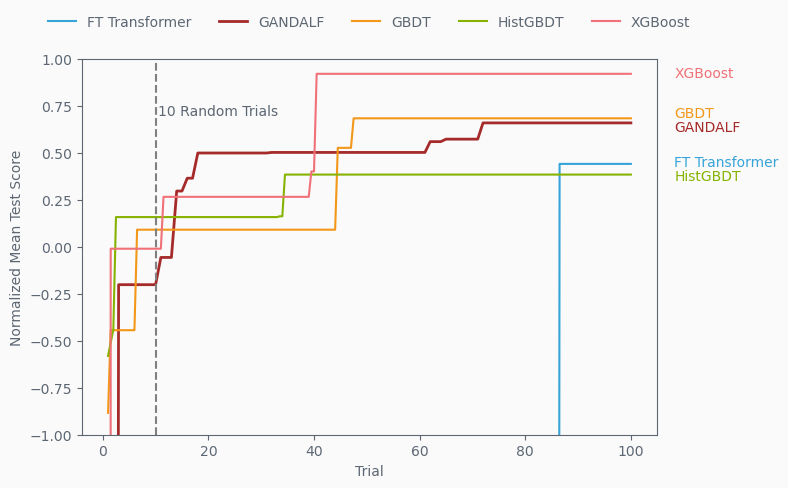

In [651]:
#plot the max_score across trials for each model in the same plot with different colors using only matplotlib
#keep legends outside the plot
with plt.style.context(matplotx.styles.ayu['light']):
    plt.figure(figsize=(8, 5))
    for mdl in models_to_plot:
        #plot thicker line for GANDALF
        if mdl == "GANDALF":
            plt.plot(trial_progress[trial_progress.Model==mdl]["Trial"], trial_progress[trial_progress.Model==mdl]["Median Test Score"], label=mdl, linewidth=2, color="brown")
        else:
            plt.plot(trial_progress[trial_progress.Model==mdl]["Trial"], trial_progress[trial_progress.Model==mdl]["Median Test Score"], label=mdl)
    plt.xlabel("Trial")
    plt.ylabel("Normalized Mean Test Score")
    #legend position top center outside the plot
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5)
    plt.ylim(-1, 1)
    #vertical dotted line at x=10 with text "Random Trials Ends"
    plt.axvline(x=10, linestyle="--", color="grey")
    plt.text(10.5, 0.7, "10 Random Trials", fontsize=10)
    plt.tight_layout()
    plt.savefig("figures/trial_progress.pdf")
    plt.show()

#### Best per Trial (Appendix)

In [768]:
# trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 75, 100]
trials = np.arange(1, 21).tolist()# + [20, 50, 75, 100]
# for each trial, find the best model for each dataset
vc_l = []
for t in trials:
    # best model for each dataset
    best_models = full_benchmark[full_benchmark.trial<=t].groupby(["benchmark", "data__keyword"])["mean_test_score"].idxmax()
    best_models = full_benchmark.loc[best_models]
    vc = best_models.model_name.value_counts()
    # vc['trial'] = t
    vc.name=f"{t}"
    vc_l.append(vc)

In [769]:
vc_df = pd.concat(vc_l, axis=1).fillna(0).T

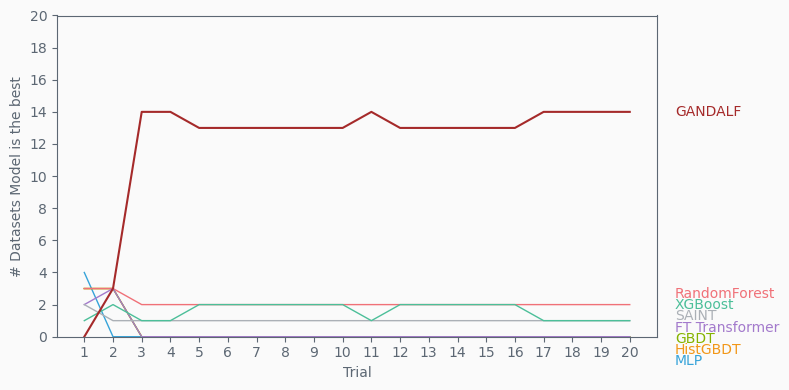

In [869]:
#plot the max_score across trials for each model in the same plot with different colors using only matplotlib
#keep legends outside the plot
with plt.style.context(matplotx.styles.ayu['light']):
    plt.figure(figsize=(8, 4))
    # for mdl in models_to_plot:
    for mdl in vc_df.columns:
        #plot thicker line for GANDALF
        if mdl == "GANDALF":
            plt.plot(vc_df[mdl], label=mdl, linewidth=1.5, color="brown")
        else:
            plt.plot(vc_df[mdl], label=mdl, linewidth=1)
    plt.xlabel("Trial")
    plt.ylabel("# Datasets Model is the best")
    #legend position top center outside the plot
    # plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5)
    matplotx.line_labels()
    plt.ylim(0, 20)
    # make y axis integer
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    #vertical dotted line at x=10 with text "Random Trials Ends"
    # plt.axvline(x=10, linestyle="--", color="grey")
    # plt.text(10.5, 70, "10 Random Trials", fontsize=10)
    plt.tight_layout()
    plt.savefig("figures/trial_progress_count_datasets.pdf", transparent=True)
    plt.show()

#### Parameter Importances Study

In [7]:
def get_study(dataset_name):
    if dataset_name == "pol":
        study_name = f"pol_{POL_CLS_UUID}"
        study = optuna.load_study(study_name=study_name, storage=f"sqlite:///study/{study_name}.db")
        return study
    else: # For cncelled and unfinished trials
        folder  = STUDY_PATH
        study_path = [f for f in folder.glob(f"*{dataset_name}*.db") if "full" not in f.name][0]
        study_name = study_path.name.split(".")[0]
        study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_path}")
        return study
            

In [9]:
# Add row for each experiment
imps_l = []
trails_l = []
for dataset in datasets:
    # print(dataset.name)
    study = get_study(dataset.name)
    best_params = study.best_params
    study_for_analysis = optuna.create_study()
    study_for_analysis.add_trials(
        filter(
            lambda trial: (
                trial.params["learning_rate"] == best_params["learning_rate"]
            )
            and (
                trial.params["optimizer_config__weight_decay"]
                == best_params["optimizer_config__weight_decay"]
            )
            and {
                trial.params["gflu_dropout"] - best_params["gflu_dropout"] <= 0.05,
            },
            study.trials,
        )
    )
    imps = optuna.importance.get_param_importances(
        study_for_analysis,
        normalize=True,
        params=["gflu_stages", "gflu_feature_init_sparsity", "gflu_dropout"],
    )
    # save imps (a dictionary) as dataframe
    imps_df = pd.DataFrame.from_dict(imps, orient="index", columns=["importance"])
    imps_df["dataset"] = dataset.name
    imps_l.append(imps_df)
    trials_df = study_for_analysis.trials_dataframe()
    trials_df["dataset"] = dataset.name
    trails_l.append(trials_df)
    trials_df = pd.concat(trails_l)

imps_df = pd.concat(imps_l).reset_index()
imps_df.rename(columns={"index": "param"}, inplace=True)
param_rename_map = {
    "gflu_stages": "GFLU Stages",
    "gflu_feature_init_sparsity": "Init Sparsity",
    "gflu_dropout": "GFLU Dropout",
    # "optimizer_config__weight_decay": "Weight Decay",
    # "learning_rate": "Learning Rate",
    # "learnable_sparsity": "Learnable Sparsity",
}
imps_df["param"] = imps_df["param"].map(param_rename_map)
param_rename_map_alt = {"params_" + k: v for k, v in param_rename_map.items()}
trials_df.rename(columns=param_rename_map_alt, inplace=True)

[I 2023-07-15 19:18:21,785] A new study created in memory with name: no-name-dd1c13a4-e9d7-4093-9e0a-aa9706daf2dd
[I 2023-07-15 19:18:22,039] A new study created in memory with name: no-name-c0d3e959-b037-40aa-b953-676305d68d8e
[I 2023-07-15 19:18:22,348] A new study created in memory with name: no-name-a115d89b-87ac-4f8b-bfb5-45c6d8d8093c
[I 2023-07-15 19:18:22,783] A new study created in memory with name: no-name-02cd0c8b-7844-4d23-908d-6151932de730
[I 2023-07-15 19:18:23,089] A new study created in memory with name: no-name-89d546b9-9554-447c-b307-ba7158bb8994
[I 2023-07-15 19:18:23,454] A new study created in memory with name: no-name-750c0bf7-be02-4b82-8e6a-092823f286f3
[I 2023-07-15 19:18:23,636] A new study created in memory with name: no-name-ab1cd2f4-c7f6-40cb-94b7-1cfcab9e7003
[I 2023-07-15 19:18:23,802] A new study created in memory with name: no-name-8092acb2-8d33-4bfd-bf22-12e72185fb71
[I 2023-07-15 19:18:24,087] A new study created in memory with name: no-name-55edd727-5c

In [10]:
c = imps_df.groupby("param")['importance'].sum().sort_values(ascending=False)
c

param
GFLU Stages      8.261624
GFLU Dropout     5.005707
Init Sparsity    4.732669
Name: importance, dtype: float64

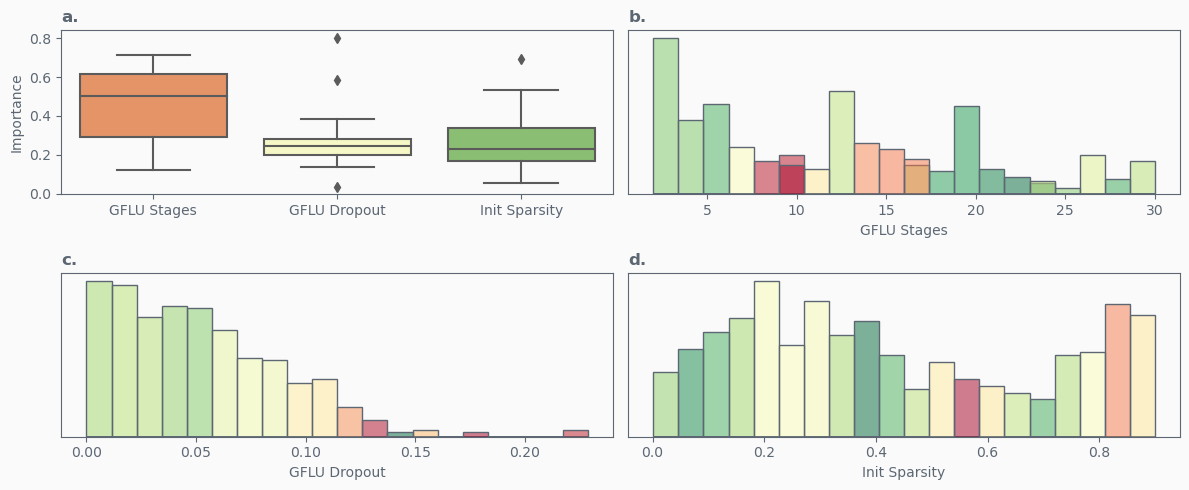

In [12]:
n_bins = 20
hyperparameters = ["box", "GFLU Stages", "GFLU Dropout", "Init Sparsity"]
labels = ["a.", "b.", "c.", "d."]
# subplots 2x2
with plt.style.context(matplotx.styles.ayu["light"]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 5))
    for i, param in enumerate(hyperparameters):
        if param == "box":
            sns.boxplot(
                x="param",
                y="importance",
                data=imps_df.loc[imps_df["param"].isin(c.index[:4])],
                order=c.index[:4],
                ax=axs[i // 2, i % 2],
                palette="RdYlGn",
            )
            # turn off x label
            axs[i // 2, i % 2].set_xlabel("")
            # set y label
            axs[i // 2, i % 2].set_ylabel("Importance")
            # reduce font of x tick labels
            # axs[i//2, i%2].tick_params(axis='x', labelsize=9.5)
            # name plot as a.
            axs[i // 2, i % 2].set_title(labels[i], loc="left", fontweight="bold")

        else:
            df = trials_df.loc[:, [param, "value"]]
            x = df[param].values
            _, bin_edges = np.histogram(x, bins=n_bins)
            df["bin"] = pd.cut(x, bins=bin_edges, labels=False, include_lowest=True)
            color = df.groupby("bin").mean()["value"]
            df["color"] = df.bin.apply(lambda k: color[k])
            df.reset_index(drop=True, inplace=True)
            df["color"] = df["color"].astype(float)
            # normalize color between 0 and 1
            df["color"] = (df["color"] - df["color"].min()) / (
                df["color"].max() - df["color"].min()
            )
            sns.histplot(
                data=df,
                x=param,
                bins=bin_edges,
                hue="color",
                palette="RdYlGn",
                ax=axs[i // 2, i % 2],
            )
            # turnoff legends
            axs[i // 2, i % 2].get_legend().remove()
            # turn off y label and axis
            axs[i // 2, i % 2].set_ylabel("")
            axs[i // 2, i % 2].set_yticks([])
            # name plot as b., c., d.
            axs[i // 2, i % 2].set_title(labels[i], loc="left", fontweight="bold")
            # turn x axis as integer for Learnable Sparsity
            if param == "Learnable Sparsity":
                axs[i // 2, i % 2].xaxis.set_major_locator(
                    matplotlib.ticker.MaxNLocator(integer=True)
                )
        # dd colorbar
        # plt.colorbar()
    plt.tight_layout()
    plt.savefig("figures/hyparameter_study.pdf", bbox_inches="tight", transparent=True)
    plt.show()
    # break

### Interpretability

#### Ranking Feature Importances (Combined with MORF & LORF)

In [571]:
from src.recmetrics import precision_at, mean_average_precision_at, ndcg_at
from collections import defaultdict

In [ ]:
def calc_feat_imp_metrics(ground_truth, eval_cols, ground_truth_topn=20, k_grid = [1, 5, 10, 15, 25, 50]):    
    labels = []
    eval_preds = defaultdict(list)
    for d in interp_df.index.get_level_values(0).unique():
        labels.append(interp_df.xs(d).sort_values(by=ground_truth, ascending=False).head(ground_truth_topn).index.tolist())
        for col in eval_cols:
            eval_preds[col].append(interp_df.xs(d).sort_values(by=col, ascending=False).index.tolist())
    res_l = []
    for k in k_grid:
        for c in eval_cols:
            preds = eval_preds[c]
            row_dict = {"k": k, "feat_imp": c}
            # row_dict["precision_at"] = precision_at(preds, labels, k)
            row_dict["MAP@K"] = mean_average_precision_at(preds, labels, k)
            row_dict["NDCG@K"] = ndcg_at(preds, labels, k)
            res_l.append(row_dict)
    return pd.DataFrame(res_l)

In [568]:
interp_df = pd.concat([pd.read_parquet(file) for file in OUTPUT_PATH.glob("feat_imp*")])
interp_df.drop(columns=["PermutationImportance_Std", "GFLU_Imp_2", "GFLU_Imp_3"], inplace=True)
interp_df.rename(columns=dict(GFLU_Imp_1="GANDALF"), inplace=True)
interp_df.set_index(['Dataset', 'Features'], inplace=True)
interp_df.head()

InputXGradient  GradientShap      DeepLift  \
Dataset  Features                                                
Ailerons climbRate    2.132477e-08     -0.000066  6.465446e-08   
         Sgz          1.312122e-08     -0.000010  8.373335e-08   
         p           -5.291551e-08     -0.000088  2.831109e-08   
         q           -4.253164e-09     -0.000515  1.002197e-07   
         curPitch     3.162438e-08      0.000158  7.292412e-08   

                    PermutationImportance   GANDALF  XGBoost  
Dataset  Features                                             
Ailerons climbRate               0.003599  0.158395      0.0  
         Sgz                     0.002672  0.032653      0.0  
         p                       0.232939  0.031719      0.0  
         q                       0.010840  0.040881      0.0  
         curPitch                0.009734  0.041524      0.0

In [604]:
shap_ranking_metrics_df = calc_feat_imp_metrics(
    ground_truth = "GradientShap", 
    eval_cols = ['GANDALF', 'XGBoost'],
    ground_truth_topn=25,
    k_grid = [1, 5, 10, 15, 25, 50]
    )
deeplift_ranking_metrics_df = calc_feat_imp_metrics(
    ground_truth = "DeepLift", 
    eval_cols = ['GANDALF', 'XGBoost'],
    ground_truth_topn=25,
    k_grid = [1, 5, 10, 15, 25, 50]
    )
# shap_res = pd.pivot_table(shap_ranking_metrics_df, index=["k"], columns=["feat_imp"], values=["MAP@K", "NDCG@K"])
# # style res with a color map
# cm = sns.light_palette("green", as_cmap=True)
# shap_res.style.background_gradient(cmap=cm, axis=1, subset=["MAP@K"]).background_gradient(cmap=cm, axis=1, subset=["NDCG@K"])

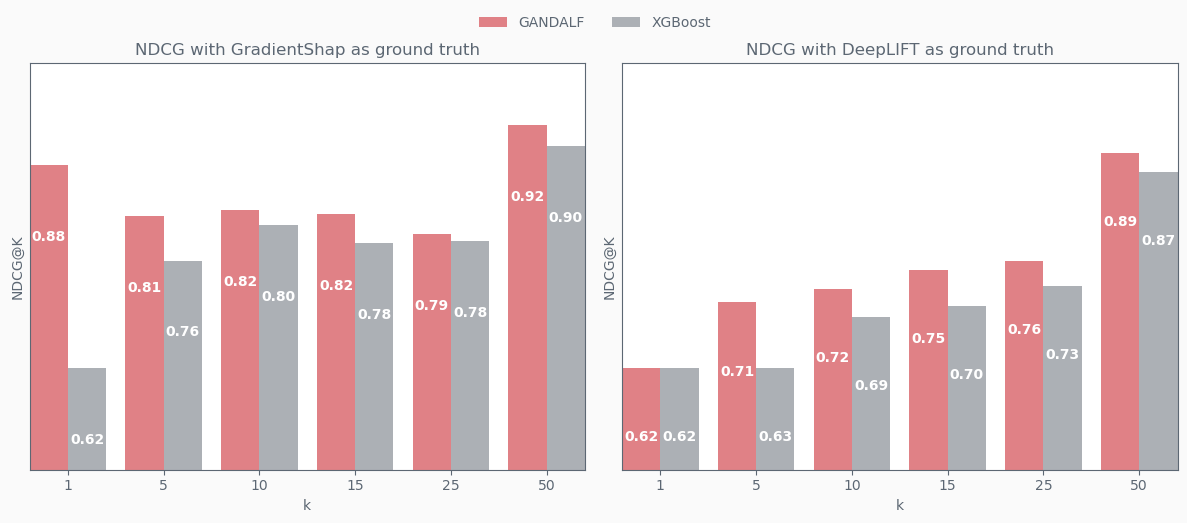

In [649]:
#bar plot: x-axis: k, y-axis: NDCG@K, each feat_imp is a bar with different color. Two plots for gradientshap and deeplift
# with plt.style.context(matplotx.styles.duftify(matplotx.styles.ayu['light'])):
gandalf_color = '#F07178'
xgboost_color = '#ABB0B6'
with plt.style.context(matplotx.styles.ayu['light']):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(x="k", y="NDCG@K", hue="feat_imp", data=shap_ranking_metrics_df, ax=ax[0], palette=[gandalf_color, xgboost_color])
    sns.barplot(x="k", y="NDCG@K", hue="feat_imp", data=deeplift_ranking_metrics_df, ax=ax[1], palette=[gandalf_color, xgboost_color])
    ax[0].set_title("NDCG with GradientShap as ground truth")
    ax[1].set_title("NDCG with DeepLIFT as ground truth")
    show_bar_values(fmt="{:.2f}", ax=ax[0], size=10)
    show_bar_values(fmt="{:.2f}", ax=ax[1], size=10)
    # single legend for both plots
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
    # turn off individual legends
    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    #y lim
    ax[0].set_ylim(0.5, 1.0)
    ax[1].set_ylim(0.5, 1.0)
    #make plot background white
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('white')

    plt.tight_layout()
    plt.savefig("figures/feat_imp_ranking_metrics.pdf")
    plt.show()



#### MORF

In [851]:
from sklearn.preprocessing import MinMaxScaler

In [852]:
morf_lorf_df = pd.concat([pd.read_parquet(file) for file in OUTPUT_PATH.glob("morf_lorf*")])

# dataset_min_max = pd.melt(morf_lorf_df, id_vars=['Dataset'], value_vars=['morf', 'lorf', 'xgb_morf', 'xgb_lorf'], var_name='feat_imp').groupby("Dataset")['value'].agg(['max', 'min'])
plot_df_morf = morf_lorf_df.loc[:, ["N", "morf", "xgb_morf", "Dataset"]]
plot_df_morf['xgb_morf'] = plot_df_morf.groupby("Dataset")["xgb_morf"].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).ravel())
plot_df_morf['morf'] = plot_df_morf.groupby("Dataset")["morf"].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).ravel())

#making Ailerons and y_prop NaN in XGboost because of highly negative results
plot_df_morf.loc[plot_df_morf.Dataset.isin(["Ailerons", "y_prop_4_1"]), "xgb_morf"] = np.nan

plot_df_morf = pd.melt(plot_df_morf, id_vars=['Dataset', 'N'], value_vars=['morf', 'xgb_morf'], value_name='test_score', var_name="Model")
plot_df_morf.Model = plot_df_morf.Model.map({"morf":"GANDALF", "xgb_morf":"XGBoost"})
plot_df_morf['N'] = plot_df_morf['N'].astype(int)
plot_df_morf

,Dataset,N,Model,test_score
0,Ailerons,0,GANDALF,1.000000
1,Ailerons,1,GANDALF,0.989826
2,Ailerons,2,GANDALF,0.976366
3,Ailerons,3,GANDALF,0.897460
4,Ailerons,4,GANDALF,0.852770
...,...,...,...,...
251,yprop_4_1,11,XGBoost,0.000000
252,yprop_4_1,12,XGBoost,0.000000
253,yprop_4_1,13,XGBoost,0.000000
254,yprop_4_1,14,XGBoost,0.000000


##### MORF - Detailed

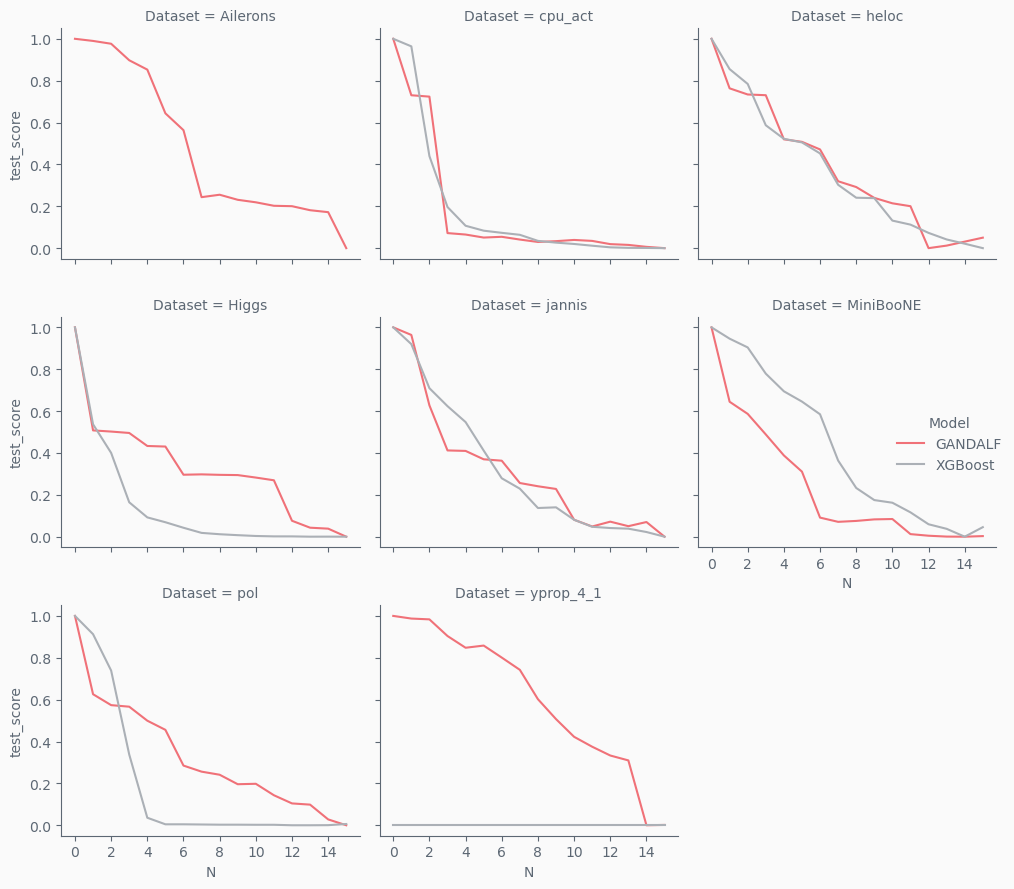

In [871]:
#hide warnings
import warnings
warnings.filterwarnings('ignore')
#lineplot: x axis N, y axis: test_score, each line is a Model, each plot is a dataset
with plt.style.context(matplotx.styles.ayu['light']):
    #plot size 10, 8
    sns.relplot(x="N", y="test_score", hue="Model", col="Dataset", col_wrap=3, kind="line", data=plot_df_morf, palette=[gandalf_color, xgboost_color], height=3, aspect=1)
    # x tick labels as integer
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    plt.ylabel("Test Score")
    #legend position
    # plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("figures/morf_detailed.pdf", bbox_inches='tight', transparent=True)
    plt.show()

##### MORF - Aggregate

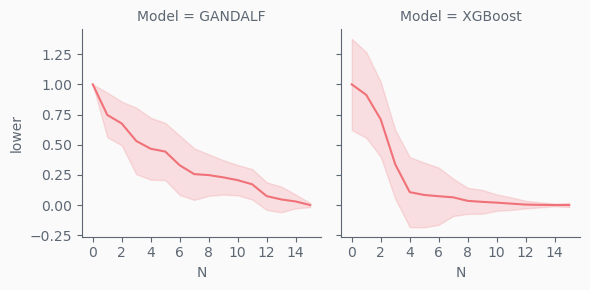

In [854]:
agg= "median"
#for each model create a mean line and a confidence band
p_morf_df = plot_df_morf.groupby(["Model", "N"])['test_score'].agg([agg, 'std']).reset_index()
p_morf_df['lower'] = p_morf_df[agg] - p_morf_df['std']
p_morf_df['upper'] = p_morf_df[agg] + p_morf_df['std']
# plot: x axis: N, y axis: test_score, line is mean test score and with shaded bands as confidence interval. Separate plots for each model
with plt.style.context(matplotx.styles.ayu['light']):
    #plot size 10, 8
    g = sns.FacetGrid(p_morf_df, col="Model", col_wrap=2, height=3, aspect=1, sharey=True)
    g.map(plt.plot, "N", agg, color=gandalf_color)
    g.map(plt.fill_between, "N", "lower", "upper", alpha=0.2, color=gandalf_color)
    # x tick labels as integer
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    plt.ylabel("Test Score")
    #legend position
    # plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("figures/morf_mean_ci.pdf")
    plt.show()
    

##### LeRF - Detailed

In [855]:
# dataset_min_max = pd.melt(morf_lorf_df, id_vars=['Dataset'], value_vars=['morf', 'lorf', 'xgb_morf', 'xgb_lorf'], var_name='feat_imp').groupby("Dataset")['value'].agg(['max', 'min'])
plot_df_lorf = morf_lorf_df.loc[:, ["N", "lorf", "xgb_lorf", "Dataset"]]
plot_df_lorf['xgb_lorf'] = plot_df_lorf.groupby("Dataset")["xgb_lorf"].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).ravel())
plot_df_lorf['lorf'] = plot_df_lorf.groupby("Dataset")["lorf"].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).ravel())

#making Ailerons and y_prop NaN in XGboost because of highly negative results
plot_df_lorf.loc[plot_df_lorf.Dataset.isin(["Ailerons", "y_prop_4_1"]), "xgb_lorf"] = np.nan

plot_df_lorf = pd.melt(plot_df_lorf, id_vars=['Dataset', 'N'], value_vars=['lorf', 'xgb_lorf'], value_name='test_score', var_name="Model")
plot_df_lorf.Model = plot_df_lorf.Model.map({"lorf":"GANDALF", "xgb_lorf":"XGBoost"})
plot_df_lorf['N'] = plot_df_lorf['N'].astype(int)
plot_df_lorf

,Dataset,N,Model,test_score
0,Ailerons,0,GANDALF,1.000000
1,Ailerons,1,GANDALF,0.999275
2,Ailerons,2,GANDALF,0.986563
3,Ailerons,3,GANDALF,0.981838
4,Ailerons,4,GANDALF,0.980895
...,...,...,...,...
251,yprop_4_1,11,XGBoost,0.000000
252,yprop_4_1,12,XGBoost,0.000000
253,yprop_4_1,13,XGBoost,0.000000
254,yprop_4_1,14,XGBoost,0.000000


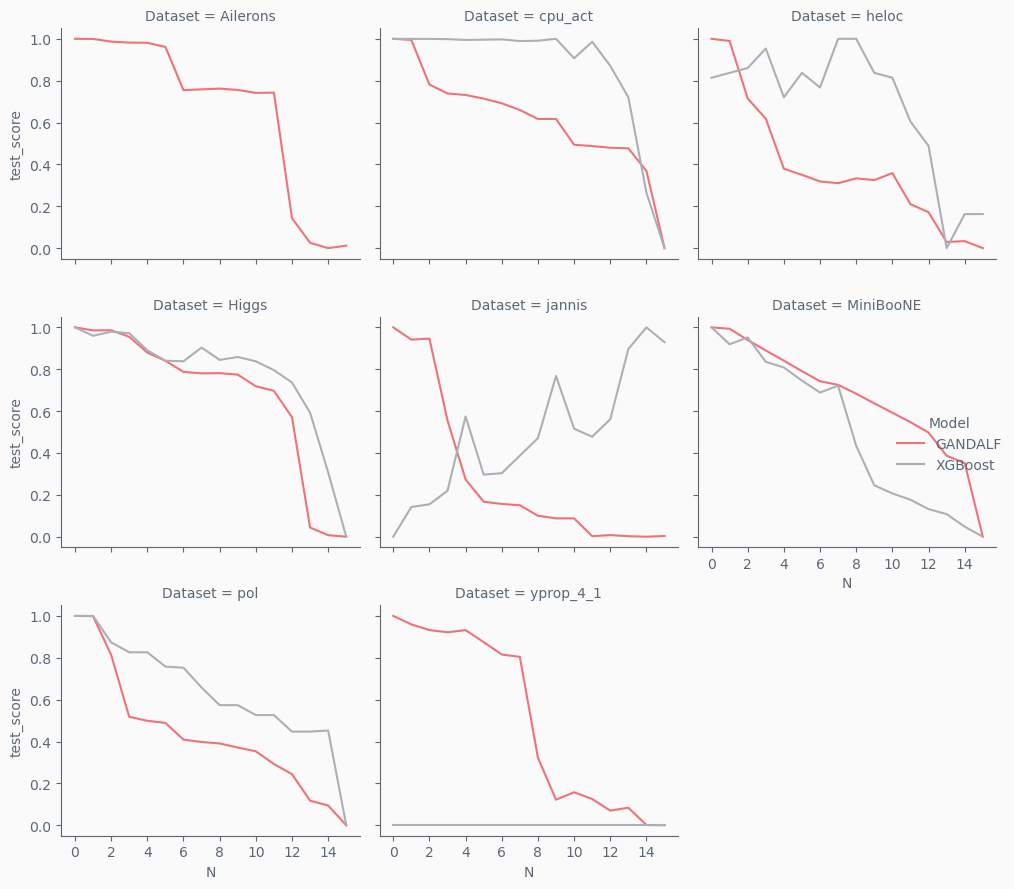

In [872]:
#hide warnings
import warnings
warnings.filterwarnings('ignore')
#lineplot: x axis N, y axis: test_score, each line is a Model, each plot is a dataset
with plt.style.context(matplotx.styles.ayu['light']):
    #plot size 10, 8
    sns.relplot(x="N", y="test_score", hue="Model", col="Dataset", col_wrap=3, kind="line", data=plot_df_lorf, palette=[gandalf_color, xgboost_color], height=3, aspect=1)
    # x tick labels as integer
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    plt.ylabel("Test Score")
    #legend position
    # plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("figures/lorf_detailed.pdf", bbox_inches='tight', transparent=True)
    plt.show()

##### LeRF Aggregated

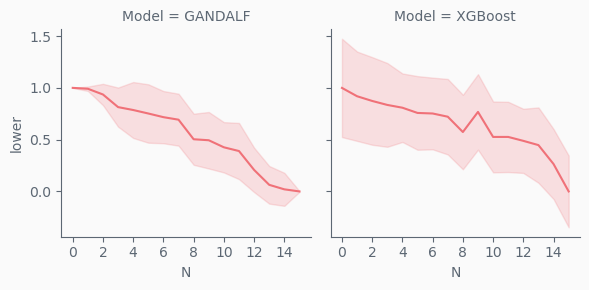

In [857]:
agg= "median"
#for each model create a mean line and a confidence band
p_lorf_df = plot_df_lorf.groupby(["Model", "N"])['test_score'].agg([agg, 'std']).reset_index()
p_lorf_df['lower'] = p_lorf_df[agg] - p_lorf_df['std']
p_lorf_df['upper'] = p_lorf_df[agg] + p_lorf_df['std']
# plot: x axis: N, y axis: test_score, line is mean test score and with shaded bands as confidence interval. Separate plots for each model
with plt.style.context(matplotx.styles.ayu['light']):
    #plot size 10, 8
    g = sns.FacetGrid(p_lorf_df, col="Model", col_wrap=2, height=3, aspect=1, sharey=True)
    g.map(plt.plot, "N", agg, color=gandalf_color)
    g.map(plt.fill_between, "N", "lower", "upper", alpha=0.2, color=gandalf_color)
    # x tick labels as integer
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    plt.ylabel("Test Score")
    #legend position
    # plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("figures/lorf_mean_ci.pdf")
    plt.show()
    

##### MORF v LeRF - Aggregate (Combined with Parameter Importances)

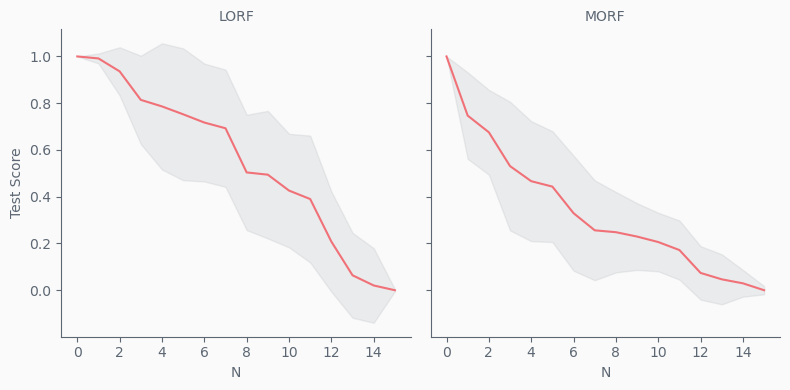

In [862]:
# line plot: x axis: N, y axis: test_score and confidence bands, each plot is `kind` - morf and lorf
p_morf_df['kind'] = "MORF"
p_lorf_df['kind'] = "LORF"
p_df = pd.concat([p_morf_df, p_lorf_df])
p_df = p_df.loc[(p_df.Model=="GANDALF")]#&(p_df.N<=15)
p_df.sort_values(by=['kind', 'N'], inplace=True)
with plt.style.context(matplotx.styles.ayu['light']):
    #plot size 10, 8
    g = sns.FacetGrid(p_df, col="kind", col_wrap=2, height=4, aspect=1, sharey=True)
    g.map(plt.plot, "N", agg, color=gandalf_color)
    g.map(plt.fill_between, "N", "lower", "upper", alpha=0.2, color=xgboost_color)
    # x tick labels as integer
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    g.set_ylabels("Test Score")
    # # set markers
    # g.map(plt.scatter, "N", agg, color=gandalf_color, marker="o")
    #legend position
    # plt.legend(loc="lower right")
    g.set_titles("{col_name}")
    plt.tight_layout()
    plt.savefig("figures/morf_lorf_mean_ci.pdf")
    plt.show()

#### MORF, LeRF, Parameter imp - Aggregate - Final

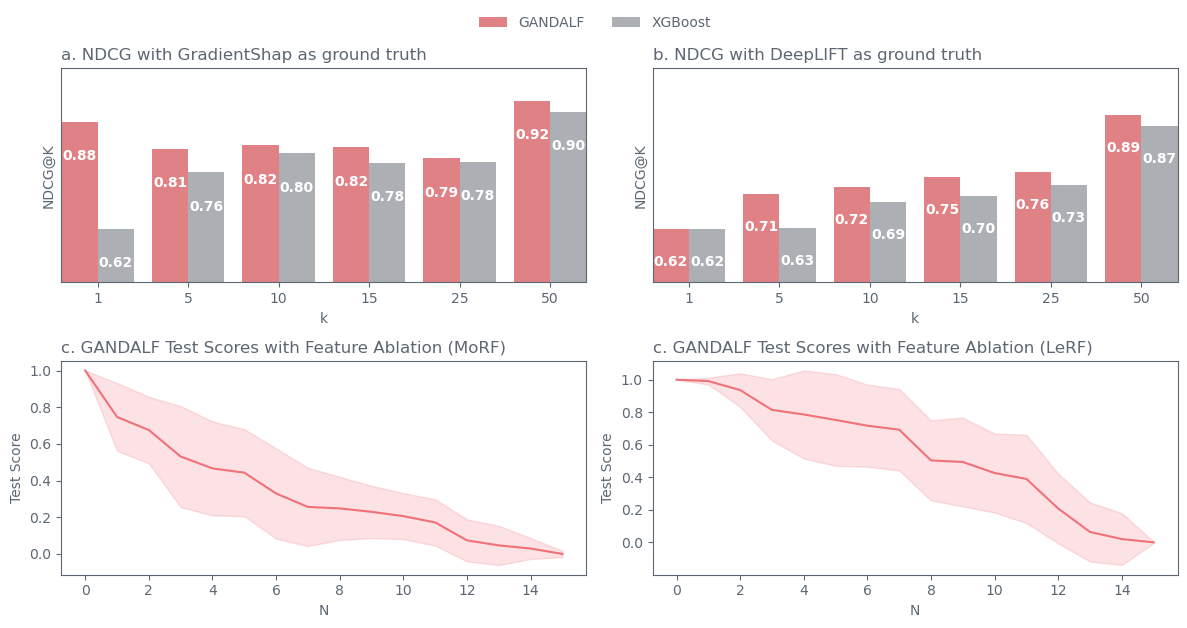

In [867]:
# bar plot: x-axis: k, y-axis: NDCG@K, each feat_imp is a bar with different color. Two plots for gradientshap and deeplift
# with plt.style.context(matplotx.styles.duftify(matplotx.styles.ayu['light'])):
gandalf_color = "#F07178"
xgboost_color = "#ABB0B6"
p_morf_df["kind"] = "MORF"
p_lorf_df["kind"] = "LORF"
p_df = pd.concat([p_morf_df, p_lorf_df])
p_df = p_df.loc[p_df.Model == "GANDALF"]
p_df.sort_values(by=["kind", "N"], inplace=True)
with plt.style.context(matplotx.styles.ayu["light"]):
    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    #canvas white
    fig.patch.set_facecolor('white')
    # each axes white
    for a in ax.flatten():
        a.patch.set_facecolor('white')
    sns.barplot(
        x="k",
        y="NDCG@K",
        hue="feat_imp",
        data=shap_ranking_metrics_df,
        ax=ax[0,0],
        palette=[gandalf_color, xgboost_color],
    )
    sns.barplot(
        x="k",
        y="NDCG@K",
        hue="feat_imp",
        data=deeplift_ranking_metrics_df,
        ax=ax[0,1],
        palette=[gandalf_color, xgboost_color],
    )
    ax[0,0].set_title("a. NDCG with GradientShap as ground truth", loc="left")
    ax[0,1].set_title("b. NDCG with DeepLIFT as ground truth", loc="left")
    show_bar_values(fmt="{:.2f}", ax=ax[0,0], size=10)
    show_bar_values(fmt="{:.2f}", ax=ax[0,1], size=10)
    # single legend for both plots
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05)
    )
    # turn off individual legends
    ax[0,0].get_legend().remove()
    ax[0,1].get_legend().remove()
    # y lim
    ax[0,0].set_ylim(0.5, 1.0)
    ax[0,1].set_ylim(0.5, 1.0)
    # make plot background white
    ax[0,0].set_facecolor("white")
    ax[0,1].set_facecolor("white")

    sns.lineplot(
        x="N",
        y=agg,
        data=p_df.loc[p_df.kind == "MORF"],
        ax=ax[1,0],
        color=gandalf_color,
    )
    ax[1,0].fill_between(
        p_df.loc[p_df.kind == "MORF"].N,
        p_df.loc[p_df.kind == "MORF"].lower,
        p_df.loc[p_df.kind == "MORF"].upper,
        alpha=0.2,
        color=gandalf_color,
    )
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    ax[1,0].set_ylabel("Test Score")
    ax[1,0].set_title("c. GANDALF Test Scores with Feature Ablation (MoRF)", loc="left")

    sns.lineplot(
        x="N",
        y=agg,
        data=p_df.loc[p_df.kind == "LORF"],
        ax=ax[1,1],
        color=gandalf_color,
    )
    ax[1,1].fill_between(
        p_df.loc[p_df.kind == "LORF"].N,
        p_df.loc[p_df.kind == "LORF"].lower,
        p_df.loc[p_df.kind == "LORF"].upper,
        alpha=0.2,
        color=gandalf_color,
    )
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    # y axis label
    ax[1,1].set_ylabel("Test Score")
    ax[1,1].set_title("c. GANDALF Test Scores with Feature Ablation (LeRF)", loc="left")
    plt.tight_layout()
    # background transparent
    plt.savefig("figures/interpretability_combined.pdf", bbox_inches='tight', transparent=True)
    plt.show()

#### Best Parameters

In [13]:
from non_informative_features_experiment import get_best_gflu_params

In [14]:
rename_cols = OrderedDict({
    "dataset": "Dataset",
    "gflu_stages": "GFLU Stages",
    "gflu_feature_init_sparsity": "Init Sparsity",
    "learnable_sparsity": "Learnable Sparsity",
    "gflu_dropout": "GFLU Dropout",
    "learning_rate": "Learning Rate",
    "optimizer_config__weight_decay": "Weight Decay",
}
)

In [16]:
param_l = []
for d in datasets:
    best_params = get_best_gflu_params({"dataset":d.name})
    best_params["dataset"] = d.name
    param_l.append(best_params)

param_df = pd.DataFrame(param_l)
param_df.dataset = param_df.dataset.map(dataset_rename_map)
param_df.rename(columns=rename_cols, inplace=True)
param_df = param_df[rename_cols.values()]
param_df["Weight Decay"] = param_df["Weight Decay"].astype(str)
param_df['Learning Rate'] = param_df['Learning Rate'].astype(str)
param_df.drop(columns=['Learnable Sparsity'], inplace=True)
param_df.head()

,Dataset,GFLU Stages,Init Sparsity,GFLU Dropout,Learning Rate,Weight Decay
0,default-credit-card,2,0.870769,0.021064,0.001,0.001
1,heloc,13,0.291414,0.072046,0.001,0.0001
2,eye_movements,2,0.802989,0.011162,0.001,0.001
3,Higgs,10,0.717149,0.087058,0.001,1e-05
4,pol,3,0.181439,0.103777,0.001,1e-07


In [17]:
print(
    param_df.to_latex(
        index=False,
        # formatters={"Type": lambda x: x.capitalize()},
        bold_rows=True,
        caption="Tuned Hyperparameters for each dataset.",
        label="tab:hyperparameters",
    )
)

\begin{table}
\centering
\caption{Tuned Hyperparameters for each dataset.}
\label{tab:hyperparameters}
\begin{tabular}{lrrrll}
\toprule
            Dataset &  GFLU Stages &  Init Sparsity &  GFLU Dropout & Learning Rate & Weight Decay \\
\midrule
default-credit-card &            2 &       0.870769 &      0.021064 &         0.001 &        0.001 \\
              heloc &           13 &       0.291414 &      0.072046 &         0.001 &       0.0001 \\
      eye\_movements &            2 &       0.802989 &      0.011162 &         0.001 &        0.001 \\
              Higgs &           10 &       0.717149 &      0.087058 &         0.001 &        1e-05 \\
                pol &            3 &       0.181439 &      0.103777 &         0.001 &        1e-07 \\
             albert &           18 &       0.007152 &      0.014137 &         0.001 &        1e-07 \\
        road-safety &           19 &       0.001146 &      0.063497 &         0.001 &        1e-05 \\
          MiniBooNE &           14 &  

C:\Users\manuj\AppData\Local\Temp\ipykernel_62672\636781186.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  param_df.to_latex(


#### TabSurvey Benchmark

In [10]:
tab_survey_df = pd.read_clipboard()

In [12]:
tab_survey_df.to_parquet("data/tab_survey_df.parquet")

In [13]:
tab_survey_df.head()

,Method,Adult,HIGGS,Covertype,Cal. Housing
0,GATE-v2,0.8906,0.8880,1.0000,1.0000
1,Linear Model,0.2344,0.3938,0.0800,0.4783
2,KNN,0.3438,0.3243,0.0000,0.6232
3,Decision Tree,0.6719,0.6718,0.3236,0.6522
4,Random Forest,0.7969,0.6950,0.2873,0.8406


In [22]:
tab_survey_df['Method'] = tab_survey_df['Method'].str.replace("GATE-v2", "GANDALF")

In [137]:
plot_df = pd.melt(tab_survey_df, id_vars=["Method"], value_vars=["Adult", "HIGGS", "Covertype", "Cal. Housing"])
plot_df.columns = ['Model', 'Dataset', 'Test Score']

In [138]:
my_order = plot_df.groupby("Model")['Test Score'].mean().sort_values(ascending=False).index

N=15
my_order = my_order[:N]
plot_df = plot_df.loc[plot_df.Model.isin(my_order)]

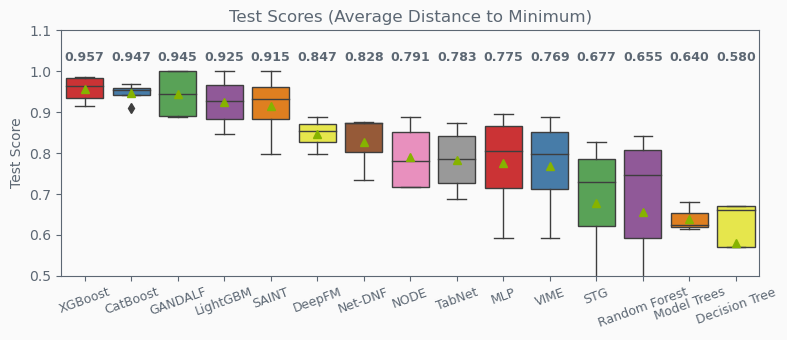

In [146]:
with plt.style.context(matplotx.styles.ayu['light']):
    fig, ax = plt.subplots(figsize=(8, 3.5))
    # fig = plt.figure(figsize=(8, 5))
    # gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    # ax1 = fig.add_subplot(gs[:-1,:])
    # ax2 = fig.add_subplot(gs[-1,:-1])
    # ax3 = fig.add_subplot(gs[-1,-1])
    # axs = [ax1, ax2, ax3]
    #box plot of mean scores
    sns.boxplot(data=plot_df, x="Model", y="Test Score", 
                # hue="Model", 
                palette="Set1",
                ax=ax, 
                order=my_order, 
                #mean
                showmeans=True,
                boxprops=dict(linewidth=1), 
                medianprops=dict(linewidth=1), 
                whiskerprops=dict(linewidth=1), 
                capprops=dict(linewidth=1))
    # Annotate mean test scores for each box
    for i, model in enumerate(my_order):
        mean_score = plot_df.loc[plot_df.Model == model, "Test Score"].mean()
        ax.annotate(
            f"{mean_score:.3f}",
            # xy=(i, mean_score),
            xy=(i, 1.0),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            #bold
            fontweight="bold",
        )
    ax.set_xlabel("")
    ax.set_ylabel("Test Score")
    ax.set_ylim(0.5, 1.1)
    #reduce font size of xticks
    plt.setp(ax.get_xticklabels(), fontsize=9)

    ax.set_title("Test Scores (Average Distance to Minimum)")
    # xtick rotation of first subplot
    plt.setp(ax.get_xticklabels(), rotation=20)
    
    #turn off legend
    # ax.legend_.remove()

    
    plt.tight_layout()
    plt.savefig("figures/aggregate_plot_tabsurvey.pdf", transparent=True, bbox_inches='tight')
    plt.show()

C:\Users\manuj\AppData\Local\Temp\ipykernel_21656\552638656.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar.set_color(plt.cm.get_cmap('tab20')(i))


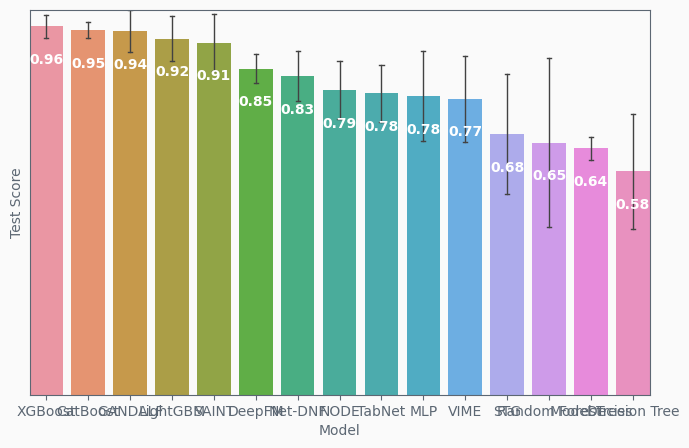

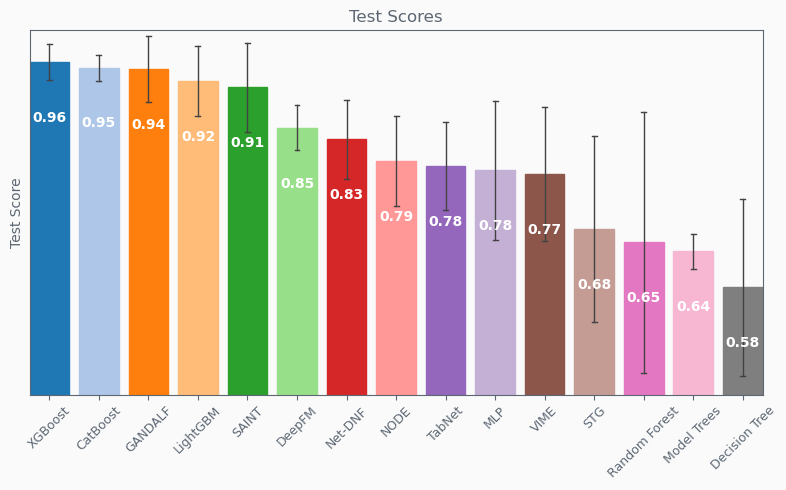

In [75]:
# plot a barchart of the mean scores
with plt.style.context(matplotx.styles.ayu['light']):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=plot_df, x="Model", y="Test Score", 
                ax=ax, 
                order=my_order,
                capsize=0.1,
                errwidth=1,
                ci="sd",
                )
    show_bar_values(fmt="{:.2f}", ax=ax, size=10)
    # set color for each bar
    for i, bar in enumerate(ax.patches):
        bar.set_color(plt.cm.get_cmap('tab20')(i))

    ax.set_xlabel("")
    ax.set_ylabel("Test Score")
    ax.set_ylim(0.4, 1.01)
    #reduce font size of xticks
    plt.setp(ax.get_xticklabels(), fontsize=9)

    ax.set_title("Test Scores")
    # xtick rotation of first subplot
    plt.setp(ax.get_xticklabels(), rotation=45)

    
    plt.tight_layout()
    plt.show()

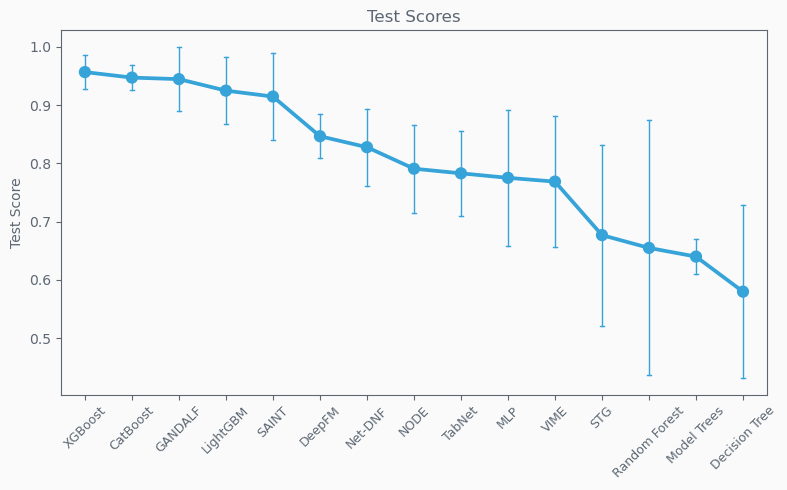

In [50]:
# lollipop plot of mean scores
with plt.style.context(matplotx.styles.ayu['light']):
    fig, ax = plt.subplots(figsize=(8, 5))
    # fig = plt.figure(figsize=(8, 5))
    # gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    # ax1 = fig.add_subplot(gs[:-1,:])
    # ax2 = fig.add_subplot(gs[-1,:-1])
    # ax3 = fig.add_subplot(gs[-1,-1])
    # axs = [ax1, ax2, ax3]
    #box plot of mean scores
    sns.pointplot(data=plot_df, x="Model", y="Test Score", 
                ax=ax, 
                order=my_order, 
                capsize=0.1,
                errwidth=1,
                ci="sd",
                )
    ax.set_xlabel("")
    ax.set_ylabel("Test Score")
    # axs[0].set_ylim(0.4, 1)
    #reduce font size of xticks
    plt.setp(ax.get_xticklabels(), fontsize=9)

    ax.set_title("Test Scores")
    # xtick rotation of first subplot
    plt.setp(ax.get_xticklabels(), rotation=45)

    
    plt.tight_layout()
    plt.show()
